# Imports

In [1]:
import matplotlib.pyplot as plt
from loadfile import *
from phonemes import *
from preprocess import *
from evaluate import *
from google_kb_z_speaker.main import *
from tqdm.auto import tqdm
from experiment_helpers import *
from functools import partial
import numpy as np
import logging
from seqmatch import *
from google_kb_z_speaker.experiments import *
from google_kb_z_speaker.preprocessing import *
import pickle

# Text processing

In [2]:
bunches = get_bunches("transcriptions")

# Experiments

## Ensemble evaluation

Here we evaluate the first ensemble created between Google and KB and perform a grid search to find the optimal phonemizer and ratio threshold

In [ ]:
phonemizer = init_phonemizer("cuda", "models/deep-phonemizer-se.pt")

In [ ]:
phonemizer("Jag_heter_nikos", "se")

In [3]:
experiment = ensemble
kwargs = {
    "bunches" : bunches,
    "device" : "cuda",
    "use_phonemizer" : True
}
args = [
    [ensemble],
    [1],
    [
        "./models/deep-phonemizer-se.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt",
        #"./models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt"
    ],
    [0.6]
]
# Convert phonemizer paths to phonemizers
phoneme_dict = read_phoneme_dict("models/stress_lex_mtm.txt")
args[2] = [ phonemizer_wrapper(init_phonemizer(kwargs["device"], x), phoneme_dict=phoneme_dict, include_stress_marks=False)
           for x in args[2]]
experiment = experiment_repeats
res = grid(experiment,args,kwargs, stub=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/911 [00:00<?, ?it/s]

AssertionError: A critical phonemizer regularity was violated with the input sequence being: ['27']

In [9]:
res[0][1]["kb_wer"].mean, res[0][1]["kb_wer"].std

(0.19164265129682997, 0.0)

In [10]:
res[0][1]["google_wer"].mean, res[0][1]["google_wer"].std

(0.1983669548511047, 0.0)

In [11]:
res[0][1]["ensemble-wer"].mean, res[0][1]["ensemble-wer"].std

(0.23791226384886327, 0.0)

In [7]:
with open("output/ensemble_eval", "rb") as f:
    res = pickle.load(f)

EOFError: Ran out of input

In [ ]:
filtered = filter(lambda x : "nidek" in x[0][0] and x[0][1] >= 0.5 and x[0][1] > 0.6, res)
min(filtered, key= lambda x: x[1]["ensemble-wer"])

## Phonemizer dict evaluation

Running the different phonemizers and testing their outputs with the provied stres__lex dictionary

In [10]:
def phonemizer_eval(model_path, device=None, stub=None):
    print("Stub is ", stub)
    phonemizer = init_phonemizer(device, model_path)
    phoneme_dict = read_phoneme_dict("./models/stress_lex_mtm.txt")
    print("Preprocessing dict")
    keys_order = list(phoneme_dict.keys())
    # Downsample
    values_order = [phoneme_dict[k] for k in keys_order]
    print("Running phonemizer")
    count_correct = 0
    outputs = []
    pbar = tqdm(list(enumerate(keys_order)))
    for i,k in pbar:
        true_phonemes = "".join(phoneme_dict[k])
        if not stub:
            phon_output = phonemizer(k,"se")
        else:
            phon_output = "a-form"
        outputs.append(phon_output)
        if phon_output==true_phonemes:
            count_correct += 1

        if i % 2000 == 0:
            pbar.set_postfix_str(f"Accuracy: {count_correct / len(keys_order):.3f}")
    output_dict = {k:v for k,v in zip(keys_order, outputs)}

    return {
        "accuracy" : count_correct / len(keys_order),
        "output_dict" : output_dict
    }

In [11]:
model_paths = [
            'models/deep-phonemizer-se.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',
            'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',
            
]
kwargs= {
    "device" : "cuda",
    "stub" : True
}
res = grid(phonemizer_eval, [model_paths], kwargs, stub=False)
res

  0%|          | 0/3 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

Stub is  True
Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

[(('models/deep-phonemizer-se.pt',),
  {'accuracy': 0.0,
   'output_dict': {'a': 'a-form',
    'a-aktier': 'a-form',
    'a-banan': 'a-form',
    'a-ekonomi': 'a-form',
    'a-et': 'a-form',
    'a-final': 'a-form',
    'a-finalen': 'a-form',
    'a-flyg': 'a-form',
    'a-form': 'a-form',
    'a-gruppen': 'a-form',
    'a-juniorer': 'a-form',
    'a-juniorerna': 'a-form',
    'a-juniorlaget': 'a-form',
    'a-kamper': 'a-form',
    'a-kassa': 'a-form',
    'a-kassan': 'a-form',
    'a-kassor': 'a-form',
    'a-kassorna': 'a-form',
    'a-lag': 'a-form',
    'a-lagare': 'a-form',
    'a-lagarna': 'a-form',
    'a-laget': 'a-form',
    'a-lagets': 'a-form',
    'a-lagsjuniorerna': 'a-form',
    'a-lagspelare': 'a-form',
    'a-lagsspelare': 'a-form',
    'a-landskamper': 'a-form',
    'a-landslag': 'a-form',
    'a-landslaget': 'a-form',
    'a-listan': 'a-form',
    'a-ljud': 'a-form',
    'a-ljudet': 'a-form',
    'a-n': 'a-form',
    'a-nummer': 'a-form',
    'a-pojke': 'a-form',
   

In [14]:
[x[0] for x in res]

[('models/deep-phonemizer-se.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt',),
 ('models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt',)]

In [12]:
print([(x[0],x[1]["accuracy"]) for x in res])
with open("output/phonemizer_eval_res", "wb") as f:
    pickle.dump(res,f)

  0%|          | 0/3 [00:00<?, ?it/s]

KeyError: 'accuracy'

### Analysis of data

In [72]:
with open("output/phonemizer_eval_res", "rb") as f:
    res = pickle.load(f)

In [73]:
model2word2pred = {x[0][0]: x[1]["output_dict"] for x in res} #DD

In [74]:
model2word2pred.keys()

dict_keys(['models/deep-phonemizer-se.pt', 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt', 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/model_step_40k.pt'])

In [75]:
models = ["deepphon", "bestmodel", "model40k"]
ids = ["deep-p", "best_model" , "model_step_40k"]
def key_translator(x):
    mask = [id_i in x for id_i in ids]
    return models[mask.index(True)]

In [76]:
model2word2pred = { key_translator(k) : v for k,v in model2word2pred.items()}

In [77]:
true_dict = read_phoneme_dict("models/stress_lex_mtm.txt")

In [83]:
model2word2pred["correct"] = true_dict 


In [84]:
word2model2pred = { word : {model : model2word2pred[model][word] for model in model2word2pred} for word in model2word2pred["correct"]}

KeyError: 'a'

In [85]:
def filter_phonemizer_predictions(word2model2pred, deepphoncorrect, bestmodelcorrect, model40kcorrect):
    res = {}
    mask = [deepphoncorrect, bestmodelcorrect, model40kcorrect]
    for word, model2pred in word2model2pred.items():
        mask_value= [model2pred["deepphon"] == model2pred["correct"],
                     model2pred["bestmodel"] == model2pred["correct"],
                     model2pred["model40k"] == model2pred["correct"]
                    ]
        if mask_value == mask:
            res[word] = model2pred


In [88]:
args = [
    [None],
    [True,False],
    [True,False],
    [True,False]
]
res = grid(filter_phonemizer_predictions, args, {}, stub=True)

  0%|          | 0/8 [00:00<?, ?it/s]

In [92]:
res = [(x[0][1:], x[1]) for x in res]

In [93]:
res

[((True, True, True), {'dummy': 0}),
 ((True, True, False), {'dummy': 0}),
 ((True, False, True), {'dummy': 0}),
 ((True, False, False), {'dummy': 0}),
 ((False, True, True), {'dummy': 0}),
 ((False, True, False), {'dummy': 0}),
 ((False, False, True), {'dummy': 0}),
 ((False, False, False), {'dummy': 0})]

## Parameterized agreement

We relax the notion of agreement and we consider that KB and Google agree only when their lcs is over a percentage of their maximum length. We then consider that in cases of agreement we keep only the largest common subsequence (LCS) of the two as the prediction.

In the following cells we test this for different threshhold levels, we produce first the WERs per threshold level and also the percentage of utterances where there is agreement

In [13]:
experiment = parameterized_agreement
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True,
    "trusted_model" : "kb",
    "threshold_range" : (0,1)
}
res = experiment(bunches, "models/deep-phonemizer-se.pt", **kwargs)

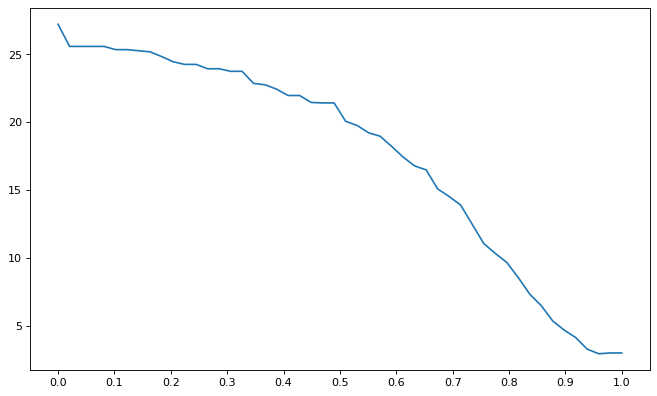

In [15]:
x = res["threshold_levels"]
y = res["agreement_wers"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ])

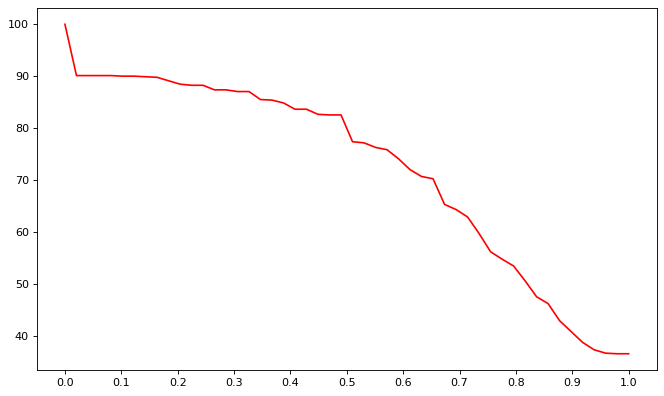

In [16]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_ratios"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ], "r")
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

## Pairwise evaluation

Here we test KB and Google, calculating their WERs under different scenarios (words, phoneme_words, singular phonemes) and also statistics percentages about 
agreement, overlap and mean-lcs

In [20]:
experiment = meval
_filter = {
    "agreement" : False,
    "g_correct" : False,
    "kb_correct" : False,
}
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : True
}
res = experiment_repeats(experiment, 5, bunches, "./models/deep-phonemizer-se.pt", **kwargs)
print_experiment_report(res)

  0%|          | 0/5 [00:00<?, ?it/s]

agreement: 0.36553238199780463±0.0
g_correct_kb_not : 0.2768166089965398±0.0
kb_correct_g_not : 0.15051903114186851±0.0
agreement_not_correct: 0.0990990990990991±0.0
both_incorrect_disagreement: 0.5726643598615917±0.0
google_wer: 0.1983669548511047±0.0
kb_wer: 0.19164265129682997±0.0
google-avg-length: 6.300768386388584±0.0
correct-avg-length: 6.856201975850714±0.0
kb-avg-length: 6.711306256860593±0.0
lcs-mean: 0.7239754234570818±0.0
error_index_overlap: 0.3029810298102981±0.0


## Randomness in phonemizer

Here we explore the phenomenon that the phonemizer can output multiple pronounciations of some words, but refrains to do it when it is called with an argument that is List[str]

In [ ]:
phonemizer = phonemizer("Hello my name is nick", lang="se")

In [ ]:
set([phonemizer("ja", "se") for x in range(100)])

In [ ]:
set(phonemizer(["ja" for x in range(10000)], "se"))

# Error analysis

In [ ]:
bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]

In [ ]:
sorted_bunch_list = sorted(bunch_list, key=lambda x : wer(x["correct"], x["kb"]))

In [ ]:
sorted_bunch_list.reverse()

In [ ]:
sorted_bunch_list

In [ ]:
str_a

In [ ]:
s.get_matching_blocks()

In [ ]:
google_lines.index("30")

In [ ]:
set(phonemizer(["jag" for x in range(10000)], "se"))

In [ ]:
set(get_swedish_phonemes(["ja" for x in range(10000)], phonemizer))

In [ ]:
s = []
for x in tqdm(range(1000)):
    torch.manual_seed(0)
    s.append(phonemizer('30', "se"))
set(s)

In [ ]:
s = []
for x in tqdm(range(15)):
    #torch.manual_seed(0)
    s.append(get_swedish_phonemes('ja', phonemizer))
set(s)

# Visualization

In [ ]:
idx = 43
size = 10
def get_triad(idx, bunch):
    #### Google, correct, Kb
    return bunch[0][idx], bunch[1][idx], bunch[2][idx]

def plot_triad(triad,ax):
    ax.text(0.0, 0.0, triad[0], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    ax.text(0, -2.5,  triad[2], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(153/255, 51/255, 0/255),
                       fc=(255/255, 153/255, 102/255),
                       )
             )
    ax.text(0, -5,  triad[1], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(42 / 255, 162 / 255, 42 / 255),
                       fc=(133 / 255, 224 / 255, 133 / 255),
                       )
             )
    
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
idx = 0
plot_triad(get_triad(idx, text_data_bunch) ,axs[0])
plot_triad(get_triad(idx, phoneme_data_bunch) ,axs[1])

In [ ]:

def print_triad_correctness(triad):
    #### Google, correct, Kb
    print("Google correct ", triad[1] == triad[0])
    print("KB correct ", triad[1] == triad[2])
    print("Agreement ", triad[0] == triad[2])
    
    print("Google WER ", wer(triad[1], triad[0]))
    print("KB WER ", wer(triad[1], triad[2]))